### Understanding euclidean distance between observed points and reference dataframe 

In [151]:
import pandas as pd
import numpy as np 
from scipy.spatial import distance
import tensorflow as tf 
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt 

In [106]:
df = pd.DataFrame(np.random.randint(0,100,size=(100, 4)), columns=list('ABCD'))
df.head(2)

,A,B,C,D
0,31,73,68,92
1,96,7,76,6


In [107]:
df_example = pd.DataFrame(np.random.randint(0,100,size=(1,4)), columns=list('ABCD')).iloc[0]
display(df_example)

A    15
B    94
C    18
D    80
Name: 0, dtype: int32

In [108]:
df_array = df_example.to_numpy()
df_array.shape 

(4,)


<!-- 
Distance = \sum_{col=0}^{Total\ Columns} Euclidean\ Distance(df[col], df_{Ref}[col])   -->
$$
d(p, q) = \sqrt({(p_1 - q_1)^2 + (p_2 - q_2)^2 + ... + (p_n - q_n)^2}) \newline 
d(p, q) = \sqrt(sum((p_i - q_i)^2 for\ i\ in\ range(n)))
$$

In [109]:
distances = df.agg(distance.euclidean, 1, v=df_example.to_numpy())
print(f'Distances:\n{distances}')
nearest_index = distances.idxmin()
nearest_index, min(distances)

Distances:
0      57.801384
1     151.558570
2      87.051709
3     109.073370
4      94.678403
         ...    
95    118.330047
96     84.770278
97     90.188691
98     69.835521
99     62.209324
Length: 100, dtype: float64


(72, 26.514147167125703)

### Hence, the row with the lowest euclidean distance is chosen as reference for this particular test-data

In [110]:
# df.loc[[nearest_index]], df_example

In [111]:
reference_point = df.loc[[nearest_index]]
print(reference_point.agg(distance.euclidean, 1, df_example.to_numpy()))
print(reference_point)
print()
df_example

72    26.514147
dtype: float64
     A   B   C   D
72  32  75  11  82



A    15
B    94
C    18
D    80
Name: 0, dtype: int32

In [112]:
# number of steps in integrated gradients
num_steps = 10

In [113]:
reference_point_arr = reference_point.iloc[0].to_numpy()
reference_point_arr.shape 

(4,)

In [114]:
reference_point_arr, df_array 

(array([32, 75, 11, 82]), array([15, 94, 18, 80]))

In [115]:
np.linspace(reference_point_arr, df_array, 5)

array([[32.  , 75.  , 11.  , 82.  ],
       [27.75, 79.75, 12.75, 81.5 ],
       [23.5 , 84.5 , 14.5 , 81.  ],
       [19.25, 89.25, 16.25, 80.5 ],
       [15.  , 94.  , 18.  , 80.  ]])

In [116]:
# Returns 2000 evenly spaced samples, calculated over the interval [reference_point_arr, df_array]
interp_output = tf.convert_to_tensor(np.linspace(reference_point_arr, df_array, num_steps))

In [117]:
interp_output.shape 

TensorShape([10, 4])

In [118]:

model = models.Sequential([
    layers.Dense(128, input_shape=(4,), activation='relu', name='dense'),
    layers.Dropout(0.5, name='dropout'),
    layers.Dense(128, activation='relu', name='dense_1'),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(128, activation='relu', name='dense_2'),
    layers.Dropout(0.5, name='dropout_2'),
    layers.Dense(1, activation='sigmoid', name='dense_3')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

D:\After\Fuse AI Trainee\proj\madi_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,793 (132.00 KB)

 Trainable params: 33,793 (132.00 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
interp_output.shape 

TensorShape([10, 4])

In [120]:
with tf.GradientTape() as tape:
    tape.watch(interp_output)
    outs = model(interp_output)

In [121]:
outs.shape

TensorShape([10, 1])

In [122]:
outs , interp_output

(<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[5.4455290e-05],
        [4.9641192e-05],
        [4.2132626e-05],
        [3.4389563e-05],
        [2.7813468e-05],
        [2.2652768e-05],
        [1.8951841e-05],
        [1.7007967e-05],
        [1.5427217e-05],
        [1.2973804e-05]], dtype=float32)>,
 <tf.Tensor: shape=(10, 4), dtype=float64, numpy=
 array([[32.        , 75.        , 11.        , 82.        ],
        [30.11111111, 77.11111111, 11.77777778, 81.77777778],
        [28.22222222, 79.22222222, 12.55555556, 81.55555556],
        [26.33333333, 81.33333333, 13.33333333, 81.33333333],
        [24.44444444, 83.44444444, 14.11111111, 81.11111111],
        [22.55555556, 85.55555556, 14.88888889, 80.88888889],
        [20.66666667, 87.66666667, 15.66666667, 80.66666667],
        [18.77777778, 89.77777778, 16.44444444, 80.44444444],
        [16.88888889, 91.88888889, 17.22222222, 80.22222222],
        [15.        , 94.        , 18.        , 80.        ]])>)

In [123]:
gradients = tape.gradient(outs, interp_output)
gradients

<tf.Tensor: shape=(10, 4), dtype=float64, numpy=
array([[-2.02911451e-06, -3.69601503e-06, -2.83344116e-06,
        -1.96727296e-06],
       [-1.33865274e-06, -2.95511677e-06, -1.87611022e-06,
        -2.46612763e-06],
       [-1.11751433e-07, -3.59705427e-06, -7.01390434e-07,
        -1.56367810e-06],
       [ 2.16653007e-07, -3.41333134e-06, -6.79029711e-07,
        -8.91003538e-07],
       [-1.84831805e-07, -2.53865414e-06, -7.83181974e-07,
        -7.93330116e-07],
       [ 2.89326749e-08, -1.79190806e-06, -9.21726382e-07,
        -9.38223707e-07],
       [-1.23133390e-07, -1.37775510e-06, -6.67743052e-07,
        -8.96050324e-07],
       [-3.64695865e-07, -9.30425642e-07, -1.86356019e-07,
        -1.16019066e-06],
       [-1.15786264e-07, -1.19211688e-06, -4.64292157e-07,
        -6.41057625e-07],
       [ 8.56318678e-08, -1.01052024e-06, -3.52140830e-07,
        -5.74296394e-07]])>

In [124]:
#gradients sum
# integral over alpha from 0 to 1 on dF/dx_i(alpha)
grad_sum = np.array(np.matrix(gradients).sum(axis=0).tolist()[0])
grad_sum 

array([-3.93674846e-06, -2.25028975e-05, -9.46541194e-06, -1.18912311e-05])

In [125]:
sum(gradients[:,0]), sum(gradients[:,1]),sum(gradients[:,2]),sum(gradients[:,3]) 

(<tf.Tensor: shape=(), dtype=float64, numpy=-3.936748456112582e-06>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-2.2502897479625972e-05>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-9.465411935138945e-06>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-1.1891231054050877e-05>)

## Sum of all gradients for every variable 

In [126]:
reference_point_arr, df_array

(array([32, 75, 11, 82]), array([15, 94, 18, 80]))

In [127]:
# for the attribution 
# IG = difference * grad_sum
# # ig_i = (x_i - x'_i) * integral over alpha from 0 to 1 on dF/dx_i(alpha)
difference_ = reference_point_arr-df_array
difference_


array([ 17, -19,  -7,   2])

In [128]:
grad_sum.shape, difference_.shape 

((4,), (4,))

In [129]:
attribution = np.multiply(grad_sum, difference_) / float(num_steps)
attribution 

array([-6.69247238e-06,  4.27555052e-05,  6.62578835e-06, -2.37824621e-06])

In [130]:
sum(attribution)

4.0310574979685045e-05

In [131]:
denom = sum([abs(val) for val in attribution])
denom 

5.845201215208817e-05

In [132]:
attribution/denom , np.matrix(gradients)

(array([-0.11449516,  0.73146336,  0.11335432, -0.04068716]),
 matrix([[-2.02911451e-06, -3.69601503e-06, -2.83344116e-06,
          -1.96727296e-06],
         [-1.33865274e-06, -2.95511677e-06, -1.87611022e-06,
          -2.46612763e-06],
         [-1.11751433e-07, -3.59705427e-06, -7.01390434e-07,
          -1.56367810e-06],
         [ 2.16653007e-07, -3.41333134e-06, -6.79029711e-07,
          -8.91003538e-07],
         [-1.84831805e-07, -2.53865414e-06, -7.83181974e-07,
          -7.93330116e-07],
         [ 2.89326749e-08, -1.79190806e-06, -9.21726382e-07,
          -9.38223707e-07],
         [-1.23133390e-07, -1.37775510e-06, -6.67743052e-07,
          -8.96050324e-07],
         [-3.64695865e-07, -9.30425642e-07, -1.86356019e-07,
          -1.16019066e-06],
         [-1.15786264e-07, -1.19211688e-06, -4.64292157e-07,
          -6.41057625e-07],
         [ 8.56318678e-08, -1.01052024e-06, -3.52140830e-07,
          -5.74296394e-07]]))

In [133]:
# getting absolute value for the attribution/explanation
attribution_ = [abs(v) for v in attribution]
attribution_ 

[6.6924723753913895e-06,
 4.275550521128935e-05,
 6.625788354597262e-06,
 2.3782462108101752e-06]

In [134]:
reference_point

,A,B,C,D
72,32,75,11,82


In [135]:
attribution 

array([-6.69247238e-06,  4.27555052e-05,  6.62578835e-06, -2.37824621e-06])

In [136]:
df.index 

RangeIndex(start=0, stop=100, step=1)

In [137]:
attribution_dict = {}
reference_point_dict = {}
for i, col in enumerate(df_example.index):
    print(col)
    attribution_dict[col] = attribution[i]
    reference_point_dict[col] = reference_point.iloc[0][col]
attribution_dict, reference_point_dict

A
B
C
D


({'A': -6.6924723753913895e-06,
  'B': 4.275550521128935e-05,
  'C': 6.625788354597262e-06,
  'D': -2.3782462108101752e-06},
 {'A': 32, 'B': 75, 'C': 11, 'D': 82})

In [138]:
df.iloc[10]['A']

40

### Plotting the Attribution Plot 

In [139]:
anomaly_score = model.predict(np.matrix(np.array(df_example)))
anomaly_score 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[1.2973827e-05]], dtype=float32)

In [145]:
df_example_val = pd.Series(df_example).astype(float)
reference_point_val = reference_point.iloc[0].astype(float)
attribution_val = pd.Series(attribution_dict).astype(float)
df_example_val, reference_point, attribution_dict

(A    15.0
 B    94.0
 C    18.0
 D    80.0
 Name: 0, dtype: float64,
      A   B   C   D
 72  32  75  11  82,
 {'A': -6.6924723753913895e-06,
  'B': 4.275550521128935e-05,
  'C': 6.625788354597262e-06,
  'D': -2.3782462108101752e-06})

In [146]:
df_attribution = pd.concat([df_example_val, reference_point_val, attribution_val], axis = 1,
                           keys=['observed_value', 'expected_value', 'attribution'], sort = True)

In [147]:
df_attribution

,observed_value,expected_value,attribution
A,15.0,32.0,-0.000007
B,94.0,75.0,0.000043
C,18.0,11.0,0.000007
D,80.0,82.0,-0.000002


In [163]:
#@title Plotting utilities
def plot_attribution(df_attribution: pd.DataFrame, anomaly_score: float) -> None:
  """Plots the attribution as a pie chart.

  The center contains the anmomaly score. The wedges are ordered clockwise
  from the most blame to the least. The percentages are the normalized
  percentages (Blame(d) / Sum of Blames). The values outside the wedges
  indicate the observed value, and the expected value in parentheses.

  Args:
    df_attribution: dataframe with observed_value, expected_value, and
    attribution for each dimension.
    anomaly_score: score ranging between Normal (1) and Anomalous (0).

  """
  df_attribution = df_attribution.sort_values(by='attribution', ascending=False)
  norm = plt.Normalize()
  names=[]
  sizes = []
  sum_big = 0
  for fn, row in df_attribution.iterrows():
    # Only show the dimensions with a blame > 5%.
    if row.attribution > 0.07:
      names.append('%s\n%3.1f (%3.1f)' %(fn, row.observed_value, row.expected_value))
      wedge_size = int(100* row.attribution)
      sum_big += wedge_size
      sizes.append(wedge_size)
  names.append('other')
  sizes.append(int(100 - sum_big))

  # Create a circle for the center of the plot
  num_p_score_steps = 100
  center_color_index  = int(num_p_score_steps*anomaly_score)
  my_circle=plt.Circle( (0,0), 0.45, facecolor=plt.cm.RdYlGn(
      norm(range(num_p_score_steps+1)))[center_color_index],
      edgecolor='white', linewidth=3)

  fig, ax = plt.subplots()
  fig.set_figheight(10)
  fig.set_figwidth(10)

  center_text = "%.2f" %(anomaly_score)
  if (center_color_index < 20 ) or (center_color_index > 80):
    text_color = 'white'
  else:
    text_color = 'black'
  ax.text(0,0,center_text, fontsize=28,horizontalalignment='center',
          color=text_color, weight="bold")

  # Custom colors --> colors will cycle
  norm = plt.Normalize()
  # Choose nine colors to cycle through to show contrast between slices.
  pie_plot = plt.pie(sizes, labels=names, colors=plt.cm.RdYlBu(norm(range(9)), alpha=0.6),
                     startangle=90, counterclock=False, autopct='%1.0f%%',
                     pctdistance=0.70, textprops=
                     dict(color="black", weight="bold", fontsize=28))

  for lab in pie_plot[1]:
    lab.set_fontsize(28)
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()


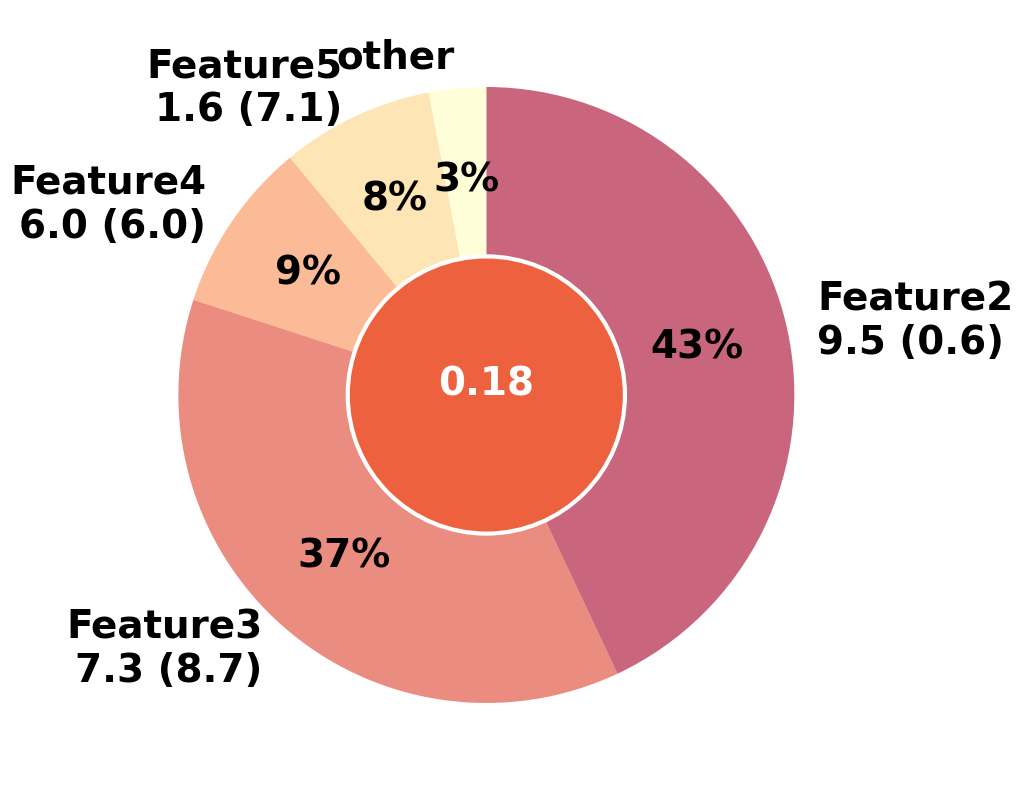

In [164]:
plot_attribution(df_attribution, anomaly_score) 

          observed_value  expected_value  attribution
Feature1        3.745401        1.559945     0.009284
Feature2        9.507143        0.580836     0.437468
Feature3        7.319939        8.661761     0.375464
Feature4        5.986585        6.011150     0.095773
Feature5        1.560186        7.080726     0.082010
Anomaly Score: 0.18340450985343382


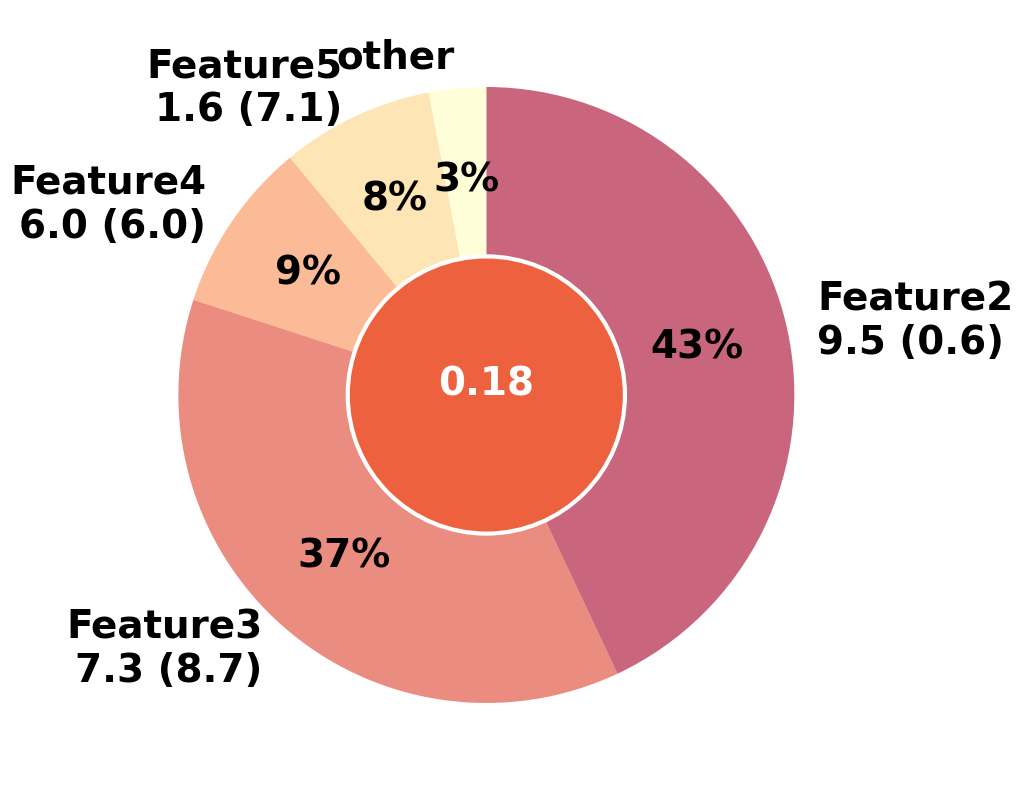

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate random data for a DataFrame
np.random.seed(42)  # For reproducibility

# Create a demo DataFrame with 5 columns: observed_value, expected_value, and attribution
df_attribution = pd.DataFrame({
    'observed_value': np.random.uniform(0, 10, 5),  # Random observed values between 0 and 10
    'expected_value': np.random.uniform(0, 10, 5),  # Random expected values between 0 and 10
    'attribution': np.random.uniform(0, 1, 5)       # Random attribution values between 0 and 1
}, index=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'])

# Normalize the attribution column to sum up to 1
df_attribution['attribution'] /= df_attribution['attribution'].sum()

# Generate a random anomaly score between 0 and 1
anomaly_score = np.random.uniform(0, 1)

print(df_attribution)
print("Anomaly Score:", anomaly_score)


plot_attribution(df_attribution, anomaly_score)
